In [34]:
import tensorflow as tf
import numpy as np
import random
import os
import copy
import time
import keras
import matplotlib.pyplot as plt

In [2]:
# check if gpu is using
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [ ]:
os.environ['KERAS_BACKEND'] = phi
import keras

In [3]:
# load model
model = keras.models.load_model('./alexnet-cifar10_origin.h5', compile=False)

In [4]:
# load datasets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape)

(50000, 32, 32, 3)


In [5]:
# get weights
theta = np.array(model.get_weights(), dtype=object)

In [23]:
# return: Population[2]
#     [0]: processed input
#     [1]: processed weight
def initPopulation(x, theta, n, input_mutation_scale, weight_mutation_scale):
    processed_x = x[np.random.randint(len(x), size=n)] # randomly choose n inputs from x
    processed_theta = theta

    # input level
    # save the mutated inputs to the GA object (i.e. self.input_x)
    if input_mutation_scale != 0 and input_mutation_scale != None:
        processed_x = (np.clip((processed_x/255 + np.random.standard_cauchy(processed_x.shape) * input_mutation_scale),0,1) * 255).astype(int)

    # weight level
    # save the mutated weights to the GA object (i.e. self.model_weights)
    if weight_mutation_scale != 0 and weight_mutation_scale != None:
        processed_theta = []
        for layer_weight in theta:
            processed_theta.append(layer_weight + np.random.standard_cauchy(layer_weight.shape) * weight_mutation_scale)

        return [processed_x, processed_theta]

In [24]:
P = initPopulation(x_test, theta, 100, 0.1, 2)

In [26]:
# Return: list of size = len(x)*number of layer
def nanFitness(P, model, phi):
    x = P[0] # n inputs chosen from dataset
    
    # compute immediate outputs from each layer
    extractor = keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])
    features = extractor.predict(x)
    
    # flatten neurons in the last layer for each input
    last_layer_outputs = features[-1].reshape((len(x), -1))
    
    # normalize neurons
    normalized_outputs = last_layer_outputs/(np.amax(last_layer_outputs) - np.amin(last_layer_outputs))
    
    fitness_values = np.amax(normalized_outputs, axis=1) - np.amin(normalized_outputs, axis=1)
    return fitness_values

In [27]:
# Population: 
#     [0]: inputs
#     [1]: weights
# phi2 will not be used if nanFitness is used
# Return: list of size = len(x)
def computeFitness(P, model, fitness_func, phi1, phi2):
    if fitness_func == "nan":
        return nanFitness(P, model, phi1)

In [29]:
Fit = computeFitness(P, model, 'nan', 'theano', 't')

In [31]:
def select(P, m, Fit):
    x = P[0]
    selected_index = np.argpartition(Fit, -m)[-m:]
    selected_x = x[selected_index]
    return selected_x

In [41]:
P_prime = select(P, 5, Fit)

In [42]:
def selectParents(P2):
    x1, x2 = random.sample(list(P2), 2)
    return x1, x2

In [49]:
x1, x2 = selectParents(P_prime)

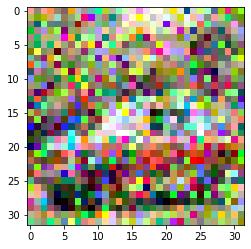

In [50]:
plt.imshow(x1)

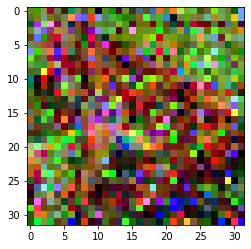

In [51]:
plt.imshow(x2)

In [72]:
# Return 1-D array with length=3072 (32*32*3)
def crossover(x1, x2, r1):
    x1_flatten = x1.flatten()
    x2_flatten = x2.flatten()
    
    # inefficient way
    x_prime = []
    for i in range(len(x1_flatten)):
        rp = random.random()
        if rp > r1:
            x_prime.append(x1_flatten[i])
        else:
            x_prime.append(x2_flatten[i])

    # efficient way
    # use numpy random generate random list
    # ...
    
    return x_prime


In [73]:
x_prime = crossover(x1, x2, 0.5)

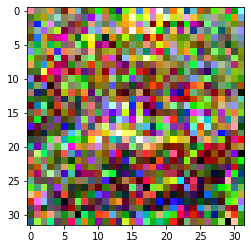

In [74]:
plt.imshow(np.array(x_prime).reshape((32,32,3)))

In [105]:
def mutate(x_prime, x_shape, mutation_scale):
    x_prime_np = np.array(x_prime)
    x_2prime=(np.clip((x_prime_np/255 + np.random.standard_cauchy(x_prime_np.shape) * mutation_scale),0,1) * 255).astype(int)
    x_2prime = x_2prime.reshape(x_shape)
    return x_2prime

In [110]:
x_2prime = mutate(x_prime, (32,32,3), 0)

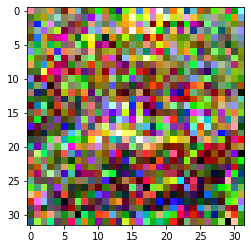

In [112]:
plt.imshow(x_2prime)

In [119]:
def checkFailed(P_2prime, model):
    x = P[0]
    F = []
    for i in x:
        try:
            f.predict(i)
        except:
            F.append(i)
    return F

In [129]:
# configure parameters
f = model     # A DNN
theta = theta # Weights of the DNN
x = x_test     # input to the DNN
phi = "tensorflow"   # the targeted DL frameworks
r1 = 0.5    # Crossover rate
r2 = 0.1    # Mutation rate
maxIter = 1    # Maximum iterations
m = 5     # Number of selected parents
n = len(x_test)


# Algorithm starts
def algo_1():
    iteration = 0
    F = {}      # A set of failed test casses
    P = initPopulation(f, x, theta, "input", 0.1, 0.2)

    while iteration < maxIter:
        iteration += 1
        Fit = computeFitness(P[0], model, "nan", phi, phi)
        P_prime = select(P, m, Fit)
        P_2prime = P_prime
        while len(P_2prime) < n:
            x1, x2 = selectParents(P_prime)
            x_prime = crossover(x1, x2, r1)
            r = random.uniform(0, 1)
            if r < r2:
                x_2prime = mutate(x_prime, r2)
                P_2prime = P_2prime.union(x_2prime)
        X = checkFailed(P_2prime)
        if X != {}:
            F = F.union(X)

            return F


In [127]:
F = {}      # A set of failed test casses
P = initPopulation(f, x, theta, "input", 0.1, 0.2)
        

In [130]:
Fit = computeFitness(P[0], model, "nan", phi, phi)

In [136]:
max(Fit)

1.0

In [141]:
P_prime = select(P, m, Fit)

In [248]:
P_2prime = list(np.expand_dims(P_prime, 1))

In [249]:
start_time = time.perf_counter()
while len(P_2prime) < 10000:
    x1, x2 = selectParents(P_prime)
    x_prime = crossover(x1, x2, r1)
    r = random.uniform(0, 1)
    if r < r2:
        x_2prime = mutate(x_prime, r2, x1.shape)
        P_2prime.append(x_2prime)
end_time = time.perf_counter()
end_time-start_time

81.82623607599817

In [250]:
new_P = [P_2prime, P[1]]

In [251]:
X,D = checkFailed(new_P, f)

In [252]:
D

[]